# Quick, Draw GAN

**W tym notebooku użyjemy kodu generatywnej sieci współzawodniczącej (Generative Adversarial Network) zaapożyczonej od [Rowela Atienzy](https://github.com/roatienza/Deep-Learning-Experiments/blob/master/Experiments/Tensorflow/GAN/dcgan_mnist.py) na licencji [MIT](https://github.com/roatienza/Deep-Learning-Experiments/blob/master/LICENSE), by stworzyć szkice na wzór rysunków stworzonych przez ludzi grających w grę [*Quick, Draw!*](https://quickdraw.withgoogle.com) (dane dostępne [tutaj](https://github.com/googlecreativelab/quickdraw-dataset) na licencji [Creative Commons](https://creativecommons.org/licenses/by/4.0/)).**

#### Zaimportujmy zależności

In [1]:
import numpy as np
import os

import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Flatten
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D
from tensorflow.keras.optimizers import Nadam

import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

#### Załadujmy dane
Bitmapowe pliki Numpy, jak zwykle 28x28 pikseli, dostępne są [tutaj](https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap) -- wybierz dowolną kategorię i z pomocą np. biblioteki requests pobierz plik.

**Zadanie 1. Załaduj wybrane dane**

In [7]:
import requests

category = "cats"
url = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/axe.npy"

response = requests.get(url)

if response.status_code == 200:

    with open(category + ".npy", "wb") as file:
        file.write(response.content)

    data = np.load(category + ".npy")

    print("Shape:", data.shape)
    print("First image:")
    print(data[2100])
else:
    print("Failed to download the file.")

Shape: (124122, 784)
First image:
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0  62  38   0   0   0   0
   0   0   0   0   0   0   0   0   0  50  11   0   0   0   0   0   0   0
   0  17 100 210 255 168   0   0   0   0   0   0   0   0   0   0   0   0
  28 255 241 189 157 136 136 136 136 170 221 255 255 200 241 155   0   0
   0   0   0   0   0   0   0   0   0   0  36 255 191 190 222 238 238 238
 238 213 162 111  50   0 239 137   0   0   0   0   0   0   0   0   0   0
   0   0  36 255  86   0   0   0   0   0   0   0   0   0   0   4 254 118
   0   0   0   0   0   0   0   0   0   0   0   0  36 255  86   0   0   0
   0   0   0   0   0   0   0  22 255 100   0   0   0   0   0   0   0   0
   0   0   0   0  36 255  86   0   0   0   0   0   0   0   0   0   0  39
 255  82   0   0   0   0   0   0   0   0   0   0   0   0  53 255  72   0
   0   0   0  29 

In [8]:
data = data/255
data = np.reshape(data,(data.shape[0],28,28,1))
img_w,img_h = data.shape[1:3]
data.shape

(124122, 28, 28, 1)

In [9]:
data[2100]

array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        

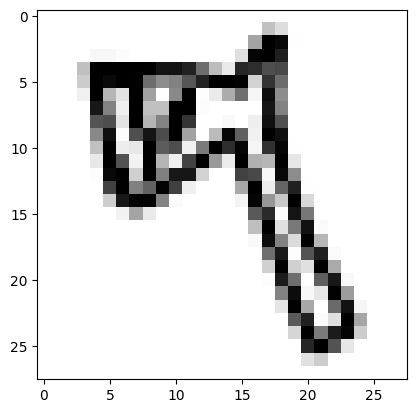

In [10]:
plt.imshow(data[4242,:,:,0], cmap='Greys')

#### Stwórzmy dyskryminator, który będziemy uczyć rozpoznawać obrazy

In [11]:
def build_discriminator(depth=64, p=0.4):

    # definiujemy wejście
    image = Input((img_w,img_h,1))

    # tworzymy warstwy konwolucyjne
    conv1 = Conv2D(depth*1, 5, strides=2, padding='same', activation='relu')(image)
    conv1 = Dropout(p)(conv1)

    conv2 = Conv2D(depth*2, 5, strides=2, padding='same', activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)

    conv3 = Conv2D(depth*4, 5, strides=2, padding='same', activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)

    conv4 = Conv2D(depth*8, 5, strides=1, padding='same', activation='relu')(conv3)
    conv4 = Flatten()(Dropout(p)(conv4))

    # warstwa wyjściowa
    prediction = Dense(1, activation='sigmoid')(conv4)

    # definicja modelu
    model = Model(inputs=image, outputs=prediction)

    return model

In [12]:
discriminator = build_discriminator()

In [13]:
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         819456    
                                                                 
 dropout_2 (Dropout)         (None, 4, 4, 256)         0     

In [14]:
discriminator.compile(loss='binary_crossentropy', optimizer=Nadam(lr=0.0008, clipvalue=1.0), metrics=['accuracy'])

#### Stwórzmy sieć generatora, którą będziemy uczyć tworzyć obrazy

In [15]:
z_dimensions = 32

In [16]:
def build_generator(latent_dim=z_dimensions, depth=64, p=0.4):

    # zdefiniowanie wejść
    noise = Input((latent_dim,))

    # pierwsza warstwa gęsta
    dense1 = Dense(7*7*depth)(noise)
    dense1 = BatchNormalization(momentum=0.9)(dense1)
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((7,7,depth))(dense1)
    dense1 = Dropout(p)(dense1)

    # sieci dekonwolucyjne
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(depth/2), kernel_size=5, padding='same', activation=None,)(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)

    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(depth/4),
                            kernel_size=5, padding='same',
                            activation=None,)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)

    conv3 = Conv2DTranspose(int(depth/8),
                            kernel_size=5, padding='same',
                            activation=None,)(conv2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)

    # warstwa wyjściowa
    image = Conv2D(1, kernel_size=5, padding='same',
                   activation='sigmoid')(conv3)

    # definicja modelu
    model = Model(inputs=noise, outputs=image)

    return model

In [17]:
generator = build_generator()

In [18]:
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_1 (Dense)             (None, 3136)              103488    
                                                                 
 batch_normalization (BatchN  (None, 3136)             12544     
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 3136)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 64)          0         
                                                           

#### Stwórzmy sieć współzawodniczącą...

In [19]:
z = Input(shape=(z_dimensions,))
img = generator(z)

In [20]:
discriminator.trainable = False

In [21]:
pred = discriminator(img)

In [22]:
adversarial_model = Model(z, pred)

In [23]:
adversarial_model.compile(loss='binary_crossentropy', optimizer=Nadam(lr=0.0004, clipvalue=1.0), metrics=['accuracy'])

#### ... i nauczmy ją (w wieeelu epokach)

**Zadanie 2.** Uzupełnij puste miejsca (`...`) w poniższej funkcji uczącej w odpowiednie fragmenty:

    1. x = np.concatenate((rimgs,fimgs))
    2. gen_imgs = generator.predict(noise)
    3. discriminator.train_on_batch(x,y)
    4. rimgs = np.reshape(data[np.random.choice(data.shape[0], batch, replace=False)], (batch,28,28,1))
    5. fimgs = generator.predict(np.random.uniform(-1.0, 1.0, size=[batch, z_dim]))
    6. adversarial_model.train_on_batch(noise,y)

In [24]:
from tqdm import tqdm
def train(epochs=2000, batch=128, z_dim=z_dimensions):

    d_metrics = []
    a_metrics = []

    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0

    for i in tqdm(range(epochs)):

        # pobierzmy prawdziwe obrazy:
        rimgs = np.reshape(data[np.random.choice(data.shape[0], batch, replace=False)], (batch,28,28,1))

        # wygenerujmy sztuczne obrazy:
        fimgs = generator.predict(np.random.uniform(-1.0, 1.0, size=[batch, z_dim]))

        # dodajmy do siebie zbiory sztucznych i prawdziwych obrazów tworząc w ten sposób wejście dyskrymintora:
        x = np.concatenate((rimgs,fimgs))

        # dodajmy etykiety:
        y = np.ones([2*batch,1])
        y[batch:,:] = 0

        # nauczmy dyskryminator:
        d_metrics.append(discriminator.train_on_batch(x,y))
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]

        # zaszumione wejście sieci współzawodniczącej oraz "prawdziwe" obrazy:
        noise = np.random.uniform(-1.0, 1.0, size=[batch, z_dim])
        y = np.ones([batch,1])

        # nauczmy sieć współzawodniczącą:
        a_metrics.append(adversarial_model.train_on_batch(noise,y))
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]

        # co jakiś czas printujmy progres i fake'owe obrazy:
        if (i+1)%20 == 0:

            print('Epoch #{}'.format(i))
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)

            noise = np.random.uniform(-1.0, 1.0, size=[16, z_dim])

            # rozpoznaj wygenerowane obrazy
            gen_imgs = generator.predict(noise)

            plt.figure(figsize=(5,5))

            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], cmap='gray')
                plt.axis('off')

            plt.tight_layout()
            plt.show()

    return a_metrics, d_metrics

  0%|          | 0/2000 [00:00<?, ?it/s]

4/4 [==============================] - 9s 5ms/step


  0%|          | 1/2000 [00:21<11:56:55, 21.52s/it]

4/4 [==============================] - 0s 3ms/step


  0%|          | 2/2000 [00:21<4:58:48,  8.97s/it] 

4/4 [==============================] - 0s 3ms/step


  0%|          | 3/2000 [00:21<2:45:47,  4.98s/it]

4/4 [==============================] - 0s 4ms/step


  0%|          | 4/2000 [00:22<1:42:36,  3.08s/it]

4/4 [==============================] - 0s 3ms/step


  0%|          | 5/2000 [00:22<1:07:30,  2.03s/it]

4/4 [==============================] - 0s 3ms/step


  0%|          | 6/2000 [00:22<46:08,  1.39s/it]  

4/4 [==============================] - 0s 3ms/step


  0%|          | 7/2000 [00:22<32:38,  1.02it/s]

4/4 [==============================] - 0s 3ms/step


  0%|          | 8/2000 [00:22<23:45,  1.40it/s]

4/4 [==============================] - 0s 3ms/step


  0%|          | 9/2000 [00:22<17:57,  1.85it/s]

4/4 [==============================] - 0s 3ms/step


  0%|          | 10/2000 [00:23<13:52,  2.39it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 11/2000 [00:23<11:05,  2.99it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 12/2000 [00:23<09:20,  3.54it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 13/2000 [00:23<07:56,  4.17it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 14/2000 [00:23<06:56,  4.77it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 15/2000 [00:23<06:43,  4.92it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 16/2000 [00:23<06:09,  5.37it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 17/2000 [00:24<05:45,  5.74it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 18/2000 [00:24<05:27,  6.06it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 19/2000 [00:24<05:18,  6.21it/s]

4/4 [==============================] - 0s 3ms/step
Epoch #19
19: [D loss: 0.482166, acc: 0.943257]  [A loss: 0.820993, acc: 0.534951]
1/1 [==============================] - 0s 212ms/step


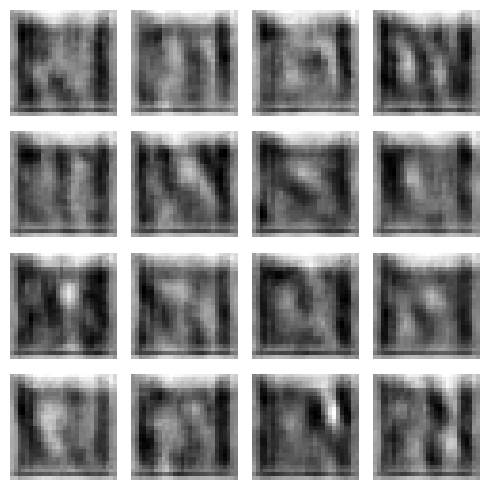

  1%|          | 20/2000 [00:25<14:19,  2.30it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 21/2000 [00:25<11:38,  2.83it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 22/2000 [00:25<09:35,  3.44it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 23/2000 [00:25<08:12,  4.02it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 24/2000 [00:26<07:12,  4.57it/s]

4/4 [==============================] - 0s 3ms/step


  1%|▏         | 25/2000 [00:26<06:27,  5.10it/s]

4/4 [==============================] - 0s 6ms/step


  1%|▏         | 26/2000 [00:26<05:59,  5.49it/s]

4/4 [==============================] - 0s 3ms/step


  1%|▏         | 27/2000 [00:26<05:37,  5.85it/s]

4/4 [==============================] - 0s 3ms/step


  1%|▏         | 28/2000 [00:26<05:23,  6.10it/s]

4/4 [==============================] - 0s 3ms/step


  1%|▏         | 29/2000 [00:26<05:13,  6.29it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 30/2000 [00:26<05:05,  6.44it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 31/2000 [00:27<05:00,  6.54it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 32/2000 [00:27<04:53,  6.71it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 33/2000 [00:27<04:55,  6.65it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 34/2000 [00:27<04:48,  6.80it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 35/2000 [00:27<04:46,  6.85it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 36/2000 [00:27<04:42,  6.96it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 37/2000 [00:27<04:38,  7.04it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 38/2000 [00:28<04:42,  6.94it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 39/2000 [00:28<04:44,  6.89it/s]

4/4 [==============================] - 0s 5ms/step
Epoch #39
39: [D loss: 0.940322, acc: 0.946114]  [A loss: 2.002954, acc: 0.680088]
1/1 [==============================] - 0s 18ms/step


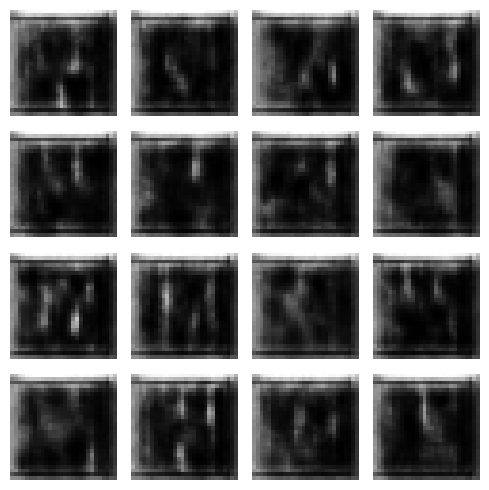

  2%|▏         | 40/2000 [00:28<10:05,  3.24it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 41/2000 [00:29<08:33,  3.82it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 42/2000 [00:29<07:21,  4.43it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 43/2000 [00:29<06:38,  4.91it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 44/2000 [00:29<06:09,  5.30it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 45/2000 [00:29<05:40,  5.75it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 46/2000 [00:29<05:23,  6.05it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 47/2000 [00:29<05:22,  6.05it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 48/2000 [00:30<05:38,  5.77it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 49/2000 [00:30<05:38,  5.76it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▎         | 50/2000 [00:30<06:04,  5.35it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 51/2000 [00:30<06:22,  5.10it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 52/2000 [00:30<06:15,  5.18it/s]

4/4 [==============================] - 0s 7ms/step


  3%|▎         | 53/2000 [00:31<06:23,  5.07it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 54/2000 [00:31<06:36,  4.90it/s]

4/4 [==============================] - 0s 5ms/step


  3%|▎         | 55/2000 [00:31<06:42,  4.83it/s]

4/4 [==============================] - 0s 5ms/step


  3%|▎         | 56/2000 [00:31<06:53,  4.70it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 57/2000 [00:32<06:34,  4.92it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 58/2000 [00:32<06:43,  4.81it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 59/2000 [00:32<06:26,  5.02it/s]

4/4 [==============================] - 0s 3ms/step
Epoch #59
59: [D loss: 0.654021, acc: 0.960805]  [A loss: 2.164036, acc: 0.465175]
1/1 [==============================] - 0s 33ms/step


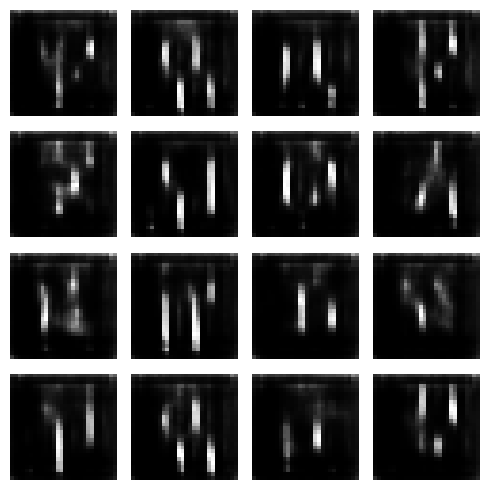

  3%|▎         | 60/2000 [00:33<14:07,  2.29it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 61/2000 [00:33<14:43,  2.19it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 62/2000 [00:34<11:59,  2.69it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 63/2000 [00:34<09:59,  3.23it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 64/2000 [00:34<08:38,  3.73it/s]

4/4 [==============================] - 0s 5ms/step


  3%|▎         | 65/2000 [00:34<09:26,  3.41it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 66/2000 [00:34<08:34,  3.76it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 67/2000 [00:35<07:37,  4.23it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 68/2000 [00:35<06:49,  4.71it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 69/2000 [00:35<06:50,  4.70it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▎         | 70/2000 [00:35<08:23,  3.84it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▎         | 71/2000 [00:36<07:40,  4.19it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▎         | 72/2000 [00:36<06:52,  4.68it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▎         | 73/2000 [00:36<06:13,  5.16it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▎         | 74/2000 [00:36<06:08,  5.23it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 75/2000 [00:36<05:44,  5.58it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 76/2000 [00:36<05:30,  5.82it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 77/2000 [00:37<05:38,  5.68it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 78/2000 [00:37<05:20,  6.01it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 79/2000 [00:37<05:25,  5.90it/s]

4/4 [==============================] - 0s 3ms/step
Epoch #79
79: [D loss: 0.575271, acc: 0.944027]  [A loss: 2.675371, acc: 0.360858]
1/1 [==============================] - 0s 18ms/step


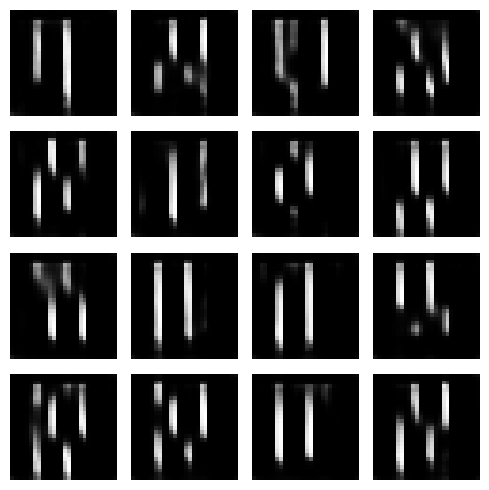

  4%|▍         | 80/2000 [00:38<10:02,  3.18it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 81/2000 [00:38<08:37,  3.71it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 82/2000 [00:38<07:32,  4.24it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 83/2000 [00:38<06:38,  4.81it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 84/2000 [00:38<06:05,  5.25it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 85/2000 [00:38<05:40,  5.62it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 86/2000 [00:38<05:22,  5.94it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 87/2000 [00:39<05:30,  5.79it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 88/2000 [00:39<05:15,  6.06it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 89/2000 [00:39<05:01,  6.34it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 90/2000 [00:39<04:52,  6.53it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 91/2000 [00:39<04:49,  6.58it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 92/2000 [00:39<04:43,  6.74it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 93/2000 [00:40<05:07,  6.21it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 94/2000 [00:40<04:55,  6.45it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 95/2000 [00:40<04:48,  6.61it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 96/2000 [00:40<04:44,  6.70it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 97/2000 [00:40<04:42,  6.73it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 98/2000 [00:40<04:53,  6.47it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 99/2000 [00:40<05:09,  6.15it/s]

4/4 [==============================] - 0s 4ms/step
Epoch #99
99: [D loss: 0.509135, acc: 0.938486]  [A loss: 3.205319, acc: 0.291193]
1/1 [==============================] - 0s 18ms/step


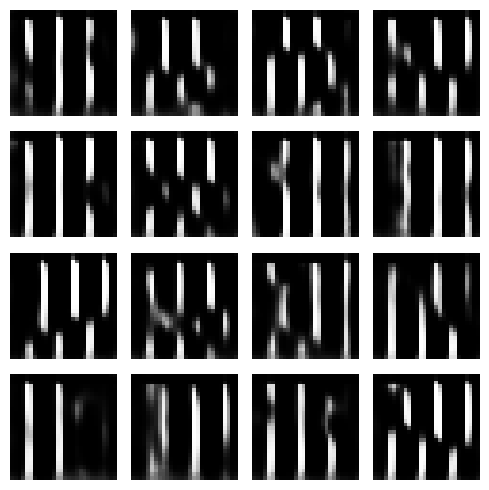

  5%|▌         | 100/2000 [00:41<13:06,  2.42it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 101/2000 [00:42<10:43,  2.95it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 102/2000 [00:42<08:54,  3.55it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 103/2000 [00:42<07:36,  4.16it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 104/2000 [00:42<06:42,  4.71it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 105/2000 [00:42<06:28,  4.88it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▌         | 106/2000 [00:42<06:09,  5.13it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▌         | 107/2000 [00:43<06:33,  4.81it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▌         | 108/2000 [00:43<07:17,  4.32it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▌         | 109/2000 [00:43<08:21,  3.77it/s]

4/4 [==============================] - 0s 7ms/step


  6%|▌         | 110/2000 [00:44<09:17,  3.39it/s]

4/4 [==============================] - 0s 8ms/step


  6%|▌         | 111/2000 [00:44<11:38,  2.70it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▌         | 112/2000 [00:45<14:54,  2.11it/s]

4/4 [==============================] - 0s 9ms/step


  6%|▌         | 113/2000 [00:45<14:12,  2.21it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▌         | 114/2000 [00:46<12:53,  2.44it/s]

4/4 [==============================] - 0s 6ms/step


  6%|▌         | 115/2000 [00:46<13:21,  2.35it/s]

4/4 [==============================] - 0s 6ms/step


  6%|▌         | 116/2000 [00:47<13:42,  2.29it/s]

4/4 [==============================] - 0s 11ms/step


  6%|▌         | 117/2000 [00:47<14:13,  2.21it/s]

4/4 [==============================] - 0s 13ms/step


  6%|▌         | 118/2000 [00:48<14:55,  2.10it/s]

4/4 [==============================] - 0s 7ms/step


  6%|▌         | 119/2000 [00:48<12:59,  2.41it/s]

4/4 [==============================] - 0s 6ms/step
Epoch #119
119: [D loss: 0.455952, acc: 0.935465]  [A loss: 3.526136, acc: 0.242975]
1/1 [==============================] - 0s 19ms/step


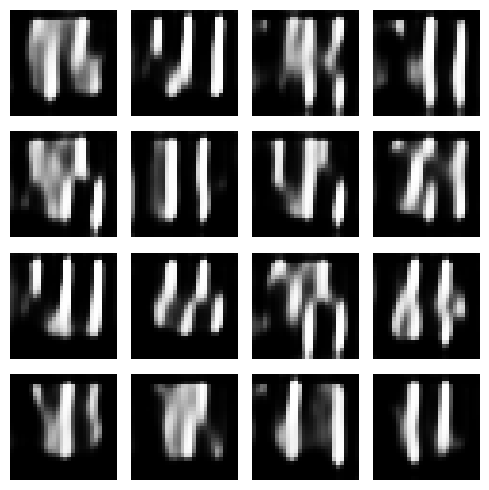

  6%|▌         | 120/2000 [00:49<19:09,  1.64it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▌         | 121/2000 [00:49<15:19,  2.04it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▌         | 122/2000 [00:49<12:19,  2.54it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▌         | 123/2000 [00:49<10:13,  3.06it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▌         | 124/2000 [00:50<08:53,  3.52it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▋         | 125/2000 [00:50<07:46,  4.02it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▋         | 126/2000 [00:50<07:19,  4.27it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 127/2000 [00:50<06:33,  4.76it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▋         | 128/2000 [00:50<05:59,  5.21it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▋         | 129/2000 [00:50<05:37,  5.54it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▋         | 130/2000 [00:51<05:23,  5.78it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 131/2000 [00:51<05:12,  5.99it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 132/2000 [00:51<05:00,  6.21it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 133/2000 [00:51<04:53,  6.35it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 134/2000 [00:51<05:10,  6.02it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 135/2000 [00:51<04:58,  6.24it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 136/2000 [00:52<04:52,  6.37it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 137/2000 [00:52<05:09,  6.02it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 138/2000 [00:52<05:26,  5.70it/s]

4/4 [==============================] - 0s 7ms/step


  7%|▋         | 139/2000 [00:52<05:18,  5.85it/s]

4/4 [==============================] - 0s 5ms/step
Epoch #139
139: [D loss: 0.413981, acc: 0.936095]  [A loss: 3.816209, acc: 0.215940]
1/1 [==============================] - 0s 27ms/step


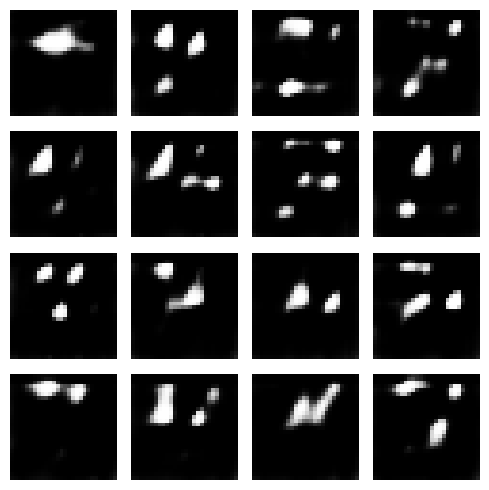

  7%|▋         | 140/2000 [00:53<10:19,  3.00it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 141/2000 [00:53<09:03,  3.42it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 142/2000 [00:53<07:41,  4.03it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 143/2000 [00:53<07:09,  4.32it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 144/2000 [00:54<06:43,  4.60it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 145/2000 [00:54<06:30,  4.76it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 146/2000 [00:54<05:59,  5.16it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 147/2000 [00:54<05:57,  5.18it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 148/2000 [00:54<05:34,  5.53it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 149/2000 [00:54<05:14,  5.88it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 150/2000 [00:54<04:59,  6.18it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 151/2000 [00:55<05:13,  5.91it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 152/2000 [00:55<05:06,  6.04it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 153/2000 [00:55<04:59,  6.17it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 154/2000 [00:55<05:16,  5.84it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 155/2000 [00:55<05:26,  5.66it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 156/2000 [00:56<05:28,  5.61it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 157/2000 [00:56<05:15,  5.85it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 158/2000 [00:56<05:00,  6.13it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 159/2000 [00:56<05:11,  5.92it/s]

4/4 [==============================] - 0s 4ms/step
Epoch #159
159: [D loss: 0.416205, acc: 0.919001]  [A loss: 3.628860, acc: 0.204599]
1/1 [==============================] - 0s 18ms/step


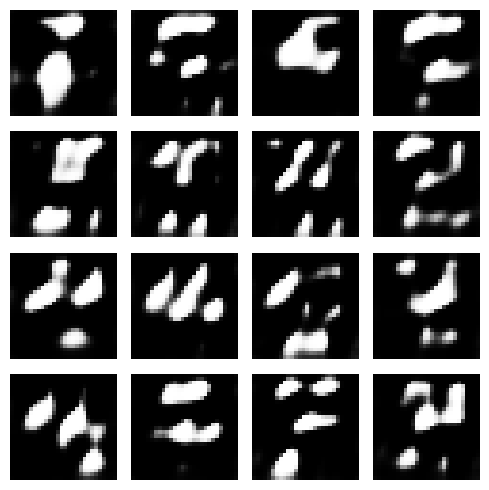

  8%|▊         | 160/2000 [00:57<10:04,  3.05it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 161/2000 [00:57<08:50,  3.46it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 162/2000 [00:57<07:38,  4.01it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 163/2000 [00:57<07:11,  4.25it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 164/2000 [00:58<06:57,  4.40it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 165/2000 [00:58<07:57,  3.84it/s]

4/4 [==============================] - 0s 9ms/step


  8%|▊         | 166/2000 [00:58<09:03,  3.37it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 167/2000 [00:59<10:20,  2.95it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 168/2000 [00:59<11:16,  2.71it/s]

4/4 [==============================] - 0s 8ms/step


  8%|▊         | 169/2000 [00:59<11:08,  2.74it/s]

4/4 [==============================] - 0s 6ms/step


  8%|▊         | 170/2000 [01:00<11:13,  2.72it/s]

4/4 [==============================] - 0s 7ms/step


  9%|▊         | 171/2000 [01:00<11:20,  2.69it/s]

4/4 [==============================] - 0s 6ms/step


  9%|▊         | 172/2000 [01:01<11:32,  2.64it/s]

4/4 [==============================] - 0s 7ms/step


  9%|▊         | 173/2000 [01:01<12:24,  2.45it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▊         | 174/2000 [01:01<11:34,  2.63it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 175/2000 [01:02<10:18,  2.95it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 176/2000 [01:02<09:20,  3.26it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 177/2000 [01:02<08:14,  3.69it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 178/2000 [01:02<07:20,  4.14it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 179/2000 [01:02<06:59,  4.35it/s]

4/4 [==============================] - 0s 4ms/step
Epoch #179
179: [D loss: 0.402386, acc: 0.914237]  [A loss: 3.505864, acc: 0.194309]
1/1 [==============================] - 0s 19ms/step


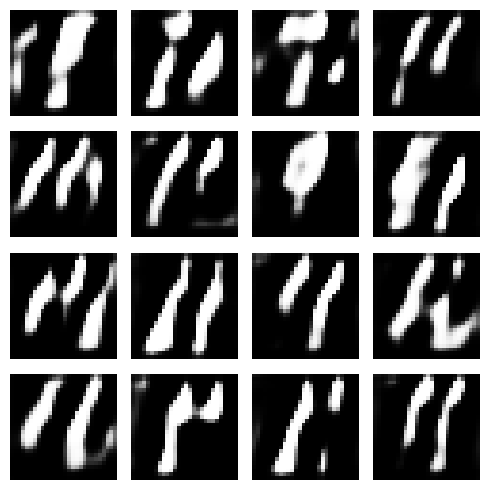

  9%|▉         | 180/2000 [01:03<14:03,  2.16it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 181/2000 [01:04<11:27,  2.65it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 182/2000 [01:04<09:29,  3.19it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 183/2000 [01:04<08:13,  3.68it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 184/2000 [01:04<07:22,  4.10it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 185/2000 [01:04<06:43,  4.50it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 186/2000 [01:05<06:39,  4.54it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 187/2000 [01:05<06:34,  4.59it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 188/2000 [01:05<06:12,  4.87it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 189/2000 [01:05<05:48,  5.20it/s]

4/4 [==============================] - 0s 4ms/step


 10%|▉         | 190/2000 [01:05<05:35,  5.39it/s]

4/4 [==============================] - 0s 7ms/step


 10%|▉         | 191/2000 [01:05<05:22,  5.61it/s]

4/4 [==============================] - 0s 4ms/step


 10%|▉         | 192/2000 [01:06<05:14,  5.75it/s]

4/4 [==============================] - 0s 4ms/step


 10%|▉         | 193/2000 [01:06<05:24,  5.57it/s]

4/4 [==============================] - 0s 3ms/step


 10%|▉         | 194/2000 [01:06<05:10,  5.81it/s]

4/4 [==============================] - 0s 3ms/step


 10%|▉         | 195/2000 [01:06<04:59,  6.03it/s]

4/4 [==============================] - 0s 4ms/step


 10%|▉         | 196/2000 [01:06<04:54,  6.12it/s]

4/4 [==============================] - 0s 4ms/step


 10%|▉         | 197/2000 [01:06<05:07,  5.86it/s]

4/4 [==============================] - 0s 4ms/step


 10%|▉         | 198/2000 [01:07<05:16,  5.70it/s]

4/4 [==============================] - 0s 4ms/step


 10%|▉         | 199/2000 [01:07<05:01,  5.98it/s]

4/4 [==============================] - 0s 6ms/step
Epoch #199
199: [D loss: 0.379401, acc: 0.916222]  [A loss: 3.425861, acc: 0.187579]
1/1 [==============================] - 0s 21ms/step


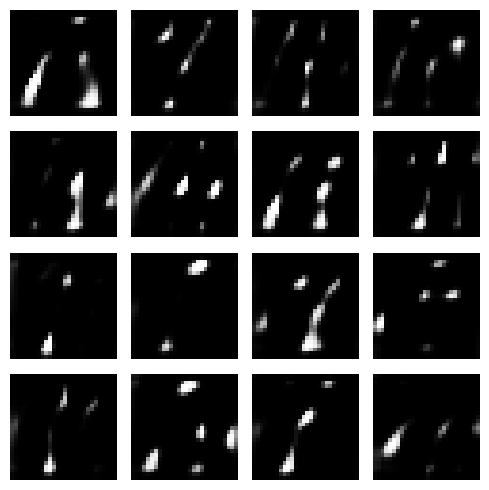

 10%|█         | 200/2000 [01:07<09:53,  3.03it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 201/2000 [01:08<08:42,  3.44it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 202/2000 [01:08<07:26,  4.02it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 203/2000 [01:08<06:38,  4.51it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 204/2000 [01:08<06:05,  4.91it/s]

4/4 [==============================] - 0s 5ms/step


 10%|█         | 205/2000 [01:08<06:02,  4.95it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 206/2000 [01:08<05:40,  5.27it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 207/2000 [01:09<05:37,  5.31it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 208/2000 [01:09<05:38,  5.29it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 209/2000 [01:09<05:22,  5.56it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 210/2000 [01:09<05:04,  5.89it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 211/2000 [01:09<04:50,  6.15it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 212/2000 [01:09<04:45,  6.27it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 213/2000 [01:10<04:58,  6.00it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█         | 214/2000 [01:10<05:05,  5.84it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 215/2000 [01:10<04:54,  6.06it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 216/2000 [01:10<04:47,  6.21it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 217/2000 [01:10<04:41,  6.34it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 218/2000 [01:10<04:39,  6.38it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 219/2000 [01:11<04:32,  6.54it/s]

4/4 [==============================] - 0s 3ms/step
Epoch #219
219: [D loss: 0.378996, acc: 0.912689]  [A loss: 3.354773, acc: 0.193850]
1/1 [==============================] - 0s 19ms/step


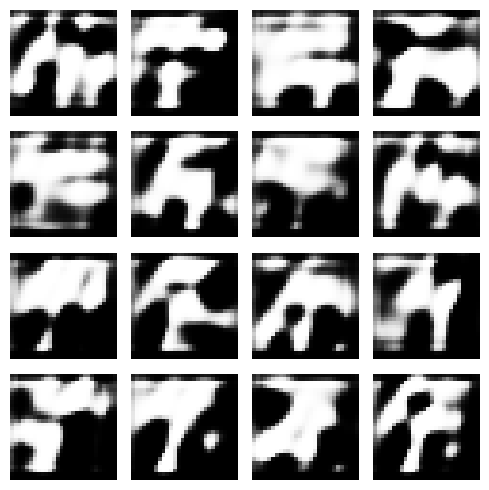

 11%|█         | 220/2000 [01:11<09:08,  3.25it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 221/2000 [01:11<08:15,  3.59it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 222/2000 [01:12<07:08,  4.15it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█         | 223/2000 [01:12<06:39,  4.45it/s]

4/4 [==============================] - 0s 6ms/step


 11%|█         | 224/2000 [01:12<06:31,  4.53it/s]

4/4 [==============================] - 0s 6ms/step


 11%|█▏        | 225/2000 [01:12<06:23,  4.63it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█▏        | 226/2000 [01:12<06:31,  4.54it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█▏        | 227/2000 [01:13<06:35,  4.48it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█▏        | 228/2000 [01:13<06:46,  4.35it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█▏        | 229/2000 [01:13<06:49,  4.33it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 230/2000 [01:13<06:38,  4.44it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 231/2000 [01:14<06:50,  4.31it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 232/2000 [01:14<06:52,  4.29it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 233/2000 [01:14<06:40,  4.41it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 234/2000 [01:14<06:48,  4.32it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 235/2000 [01:15<06:54,  4.25it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 236/2000 [01:15<06:39,  4.42it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 237/2000 [01:15<06:51,  4.29it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▏        | 238/2000 [01:15<06:46,  4.33it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▏        | 239/2000 [01:15<06:54,  4.25it/s]

4/4 [==============================] - 0s 3ms/step
Epoch #239
239: [D loss: 0.365816, acc: 0.912722]  [A loss: 3.289818, acc: 0.198908]
1/1 [==============================] - 0s 25ms/step


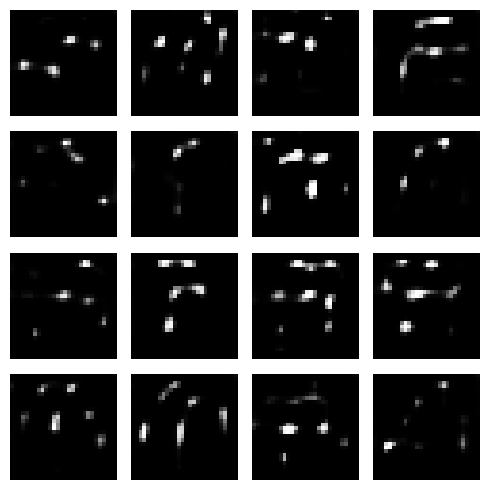

 12%|█▏        | 240/2000 [01:16<11:32,  2.54it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 241/2000 [01:16<09:42,  3.02it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▏        | 242/2000 [01:17<08:37,  3.39it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 243/2000 [01:17<07:54,  3.70it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 244/2000 [01:17<07:04,  4.14it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 245/2000 [01:17<06:31,  4.48it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 246/2000 [01:18<08:57,  3.26it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 247/2000 [01:18<07:53,  3.70it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 248/2000 [01:18<07:24,  3.94it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 249/2000 [01:18<06:49,  4.28it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▎        | 250/2000 [01:18<06:23,  4.57it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 251/2000 [01:19<06:05,  4.78it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 252/2000 [01:19<05:54,  4.94it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 253/2000 [01:19<06:02,  4.82it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 254/2000 [01:19<05:53,  4.94it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 255/2000 [01:19<06:05,  4.78it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 256/2000 [01:20<05:47,  5.02it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 257/2000 [01:20<05:33,  5.22it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 258/2000 [01:20<05:43,  5.07it/s]

4/4 [==============================] - 0s 7ms/step


 13%|█▎        | 259/2000 [01:20<05:35,  5.18it/s]

4/4 [==============================] - 0s 4ms/step
Epoch #259
259: [D loss: 0.353040, acc: 0.914213]  [A loss: 3.258616, acc: 0.188918]
1/1 [==============================] - 0s 23ms/step


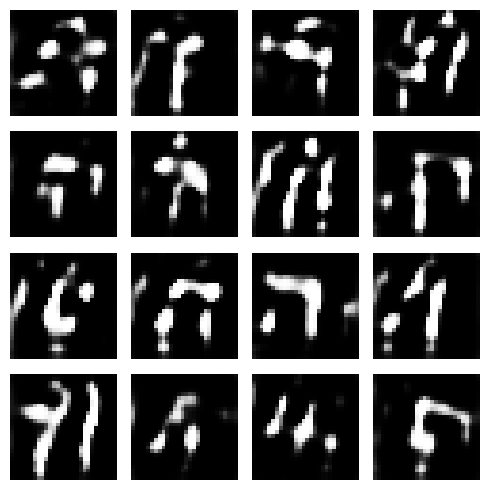

 13%|█▎        | 260/2000 [01:21<10:05,  2.88it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 261/2000 [01:21<09:05,  3.19it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 262/2000 [01:21<07:55,  3.66it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 263/2000 [01:22<06:57,  4.16it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 264/2000 [01:22<06:17,  4.60it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 265/2000 [01:22<06:09,  4.70it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 266/2000 [01:22<05:44,  5.03it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 267/2000 [01:22<05:44,  5.02it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 268/2000 [01:22<05:43,  5.04it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 269/2000 [01:23<05:46,  4.99it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▎        | 270/2000 [01:23<05:51,  4.92it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▎        | 271/2000 [01:23<05:34,  5.17it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▎        | 272/2000 [01:23<05:17,  5.43it/s]

4/4 [==============================] - 0s 8ms/step


 14%|█▎        | 273/2000 [01:23<05:04,  5.67it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▎        | 274/2000 [01:24<05:11,  5.54it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 275/2000 [01:24<05:14,  5.48it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 276/2000 [01:24<05:16,  5.44it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 277/2000 [01:24<05:01,  5.72it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 278/2000 [01:24<05:10,  5.54it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▍        | 279/2000 [01:24<05:16,  5.44it/s]

4/4 [==============================] - 0s 3ms/step
Epoch #279
279: [D loss: 0.350642, acc: 0.911150]  [A loss: 3.206127, acc: 0.181284]
1/1 [==============================] - 0s 20ms/step


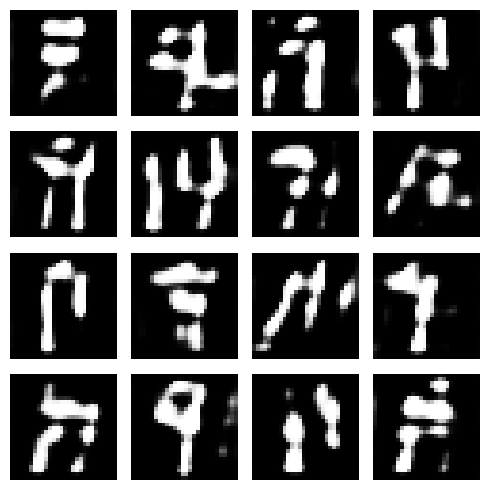

 14%|█▍        | 280/2000 [01:25<09:37,  2.98it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 281/2000 [01:25<08:24,  3.41it/s]

4/4 [==============================] - 0s 6ms/step


 14%|█▍        | 282/2000 [01:26<07:36,  3.76it/s]

4/4 [==============================] - 0s 6ms/step


 14%|█▍        | 283/2000 [01:26<07:19,  3.90it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 284/2000 [01:26<07:08,  4.01it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▍        | 285/2000 [01:26<07:05,  4.03it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▍        | 286/2000 [01:26<06:56,  4.12it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 287/2000 [01:27<07:01,  4.07it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▍        | 288/2000 [01:27<06:58,  4.09it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 289/2000 [01:27<06:59,  4.08it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 290/2000 [01:27<06:41,  4.26it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 291/2000 [01:28<06:44,  4.22it/s]

4/4 [==============================] - 0s 7ms/step


 15%|█▍        | 292/2000 [01:28<06:33,  4.34it/s]

4/4 [==============================] - 0s 7ms/step


 15%|█▍        | 293/2000 [01:28<06:37,  4.30it/s]

4/4 [==============================] - 0s 6ms/step


 15%|█▍        | 294/2000 [01:28<06:35,  4.31it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 295/2000 [01:29<06:38,  4.27it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▍        | 296/2000 [01:29<06:52,  4.14it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▍        | 297/2000 [01:29<06:51,  4.14it/s]

4/4 [==============================] - 0s 6ms/step


 15%|█▍        | 298/2000 [01:29<06:53,  4.11it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 299/2000 [01:30<06:39,  4.26it/s]

4/4 [==============================] - 0s 4ms/step
Epoch #299
299: [D loss: 0.341396, acc: 0.911541]  [A loss: 3.247972, acc: 0.172162]
1/1 [==============================] - 0s 19ms/step


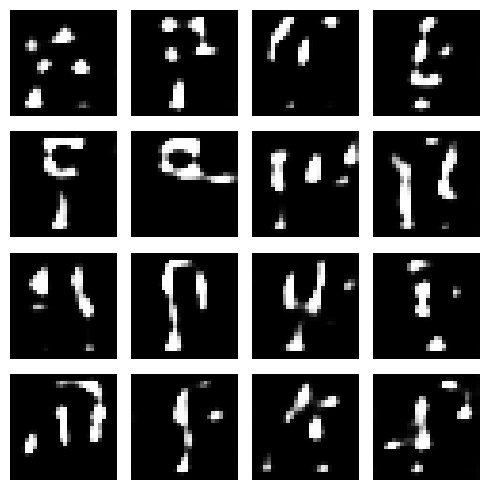

 15%|█▌        | 300/2000 [01:30<10:50,  2.61it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▌        | 301/2000 [01:31<09:33,  2.96it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▌        | 302/2000 [01:31<08:15,  3.43it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▌        | 303/2000 [01:31<07:18,  3.87it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▌        | 304/2000 [01:31<06:53,  4.10it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▌        | 305/2000 [01:31<06:18,  4.48it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▌        | 306/2000 [01:31<06:16,  4.50it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▌        | 307/2000 [01:32<05:56,  4.75it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▌        | 308/2000 [01:32<05:56,  4.75it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▌        | 309/2000 [01:32<05:56,  4.74it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 310/2000 [01:32<05:31,  5.09it/s]

4/4 [==============================] - 0s 6ms/step


 16%|█▌        | 311/2000 [01:32<05:14,  5.37it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 312/2000 [01:33<05:02,  5.59it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 313/2000 [01:33<04:50,  5.81it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 314/2000 [01:33<04:42,  5.98it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 315/2000 [01:33<04:38,  6.06it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▌        | 316/2000 [01:33<04:55,  5.69it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 317/2000 [01:33<04:44,  5.93it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 318/2000 [01:34<04:33,  6.14it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 319/2000 [01:34<04:50,  5.78it/s]

4/4 [==============================] - 0s 5ms/step
Epoch #319
319: [D loss: 0.332521, acc: 0.912201]  [A loss: 3.280187, acc: 0.166046]
1/1 [==============================] - 0s 32ms/step


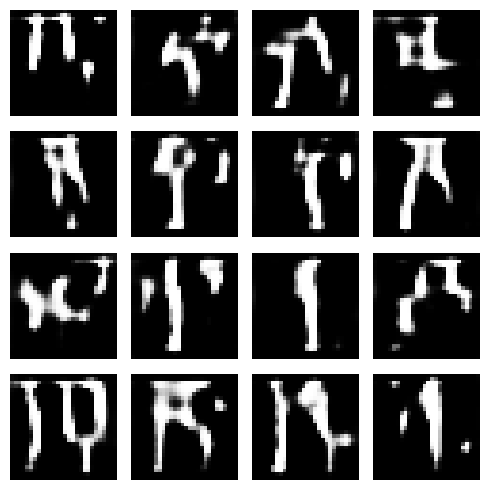

 16%|█▌        | 320/2000 [01:35<11:46,  2.38it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▌        | 321/2000 [01:35<09:39,  2.90it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▌        | 322/2000 [01:35<08:21,  3.35it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 323/2000 [01:35<07:15,  3.85it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 324/2000 [01:35<06:43,  4.15it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▋        | 325/2000 [01:36<06:24,  4.36it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▋        | 326/2000 [01:36<05:51,  4.76it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▋        | 327/2000 [01:36<05:45,  4.84it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▋        | 328/2000 [01:36<05:22,  5.19it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▋        | 329/2000 [01:36<05:04,  5.49it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▋        | 330/2000 [01:37<05:08,  5.41it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 331/2000 [01:37<05:18,  5.25it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 332/2000 [01:37<05:00,  5.55it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 333/2000 [01:37<04:50,  5.74it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█▋        | 334/2000 [01:37<05:01,  5.53it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█▋        | 335/2000 [01:37<04:45,  5.83it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█▋        | 336/2000 [01:38<04:53,  5.66it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 337/2000 [01:38<04:59,  5.55it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 338/2000 [01:38<05:05,  5.45it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 339/2000 [01:38<04:52,  5.68it/s]

4/4 [==============================] - 0s 3ms/step
Epoch #339
339: [D loss: 0.321926, acc: 0.914178]  [A loss: 3.329874, acc: 0.158601]
1/1 [==============================] - 0s 32ms/step


In [ ]:
a_metrics_complete, d_metrics_complete = train()

#### Zbierzmy statystyki

In [ ]:
ax = pd.DataFrame(
    {
        'Adversarial': [metric[0] for metric in a_metrics_complete],
        'Discriminator': [metric[0] for metric in d_metrics_complete],
    }
).plot(title='Training Loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

In [ ]:
ax = pd.DataFrame(
    {
        'Adversarial': [metric[1] for metric in a_metrics_complete],
        'Discriminator': [metric[1] for metric in d_metrics_complete],
    }
).plot(title='Training Accuracy')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")